# Gaussian Mixture

It is an extension of the ideas behind k-means

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                      cluster_std=0.60, random_state=0)
X = X[:, ::-1]

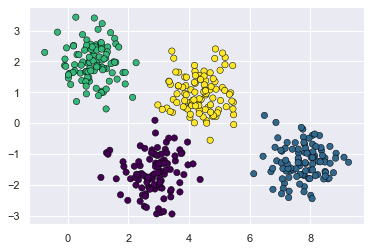

In [4]:
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis',
           linewidths=0.5, edgecolors='black')

One of the main disadvantage of k-means is that there is no probabilistic value for the clustering

In [10]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)
    
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', zorder=2)
    
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max() 
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', 
                               lw=3, alpha=0.5, zorder=1))

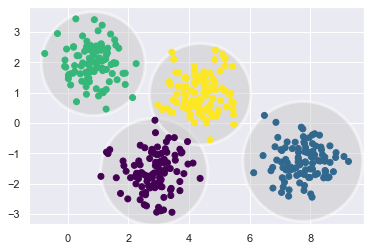

In [11]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

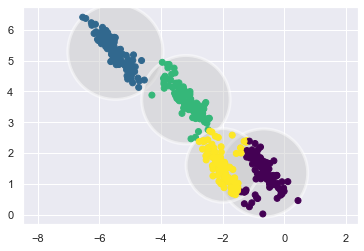

In [12]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

### Generalizing EM

A GMM attempts to find a mixture of multi-dimensional probability distributions that best model any dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as KMeans

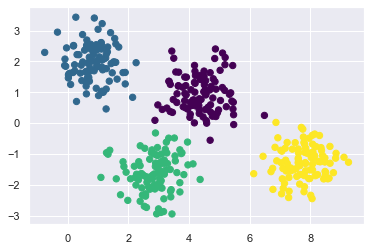

In [15]:
from sklearn.mixture import GaussianMixture as GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis')

In [16]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.531 0.    0.    0.469]
 [0.    0.    1.    0.   ]
 [0.    0.    1.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    1.    0.   ]]


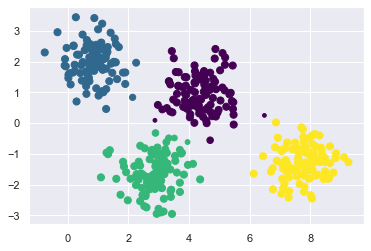

In [17]:
size = 50 * probs.max(1) ** 2
plt.scatter(X[:, 0], X[:, 1], c=labels,
           cmap='viridis', s=size)

GMM follows a model very similar to k-means:
- Choose starting guesses for location and shape
- Repeat until converged:
    - E-step: for each point, find weights encoding the probability of membership in each cluster
    - M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights



This approach, just like k-means, also has an issue with not arriving at the globally optimal solution sometimes

In [27]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
        
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height, 
                            angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    
    if label:
        ax.scatter(X[:, 0], X[:, 1], 
                   c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

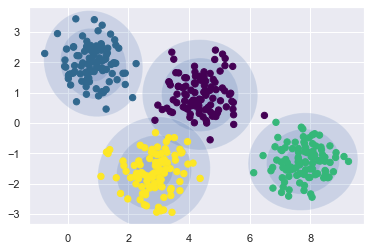

In [28]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

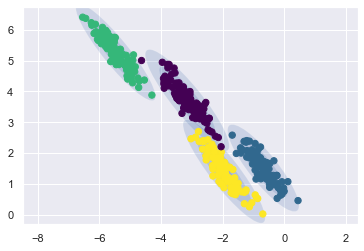

In [29]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

The above models show that GMM addresses 2 of the main concerns that K-means has

### GMM as Density Estimation

GMM is fundamentally a probabilistic model describing the distribution of the data

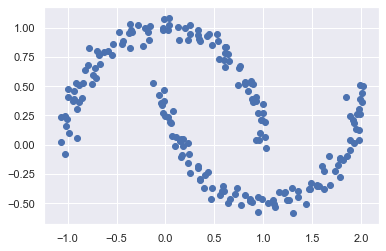

In [31]:
from sklearn.datasets import make_moons
X_moon, y_moon = make_moons(200, noise=0.05, random_state=0)
plt.scatter(X_moon[:, 0], X_moon[:, 1])

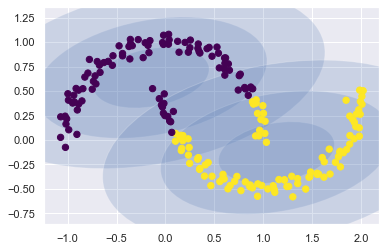

In [32]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, X_moon)

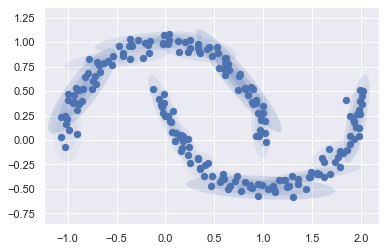

In [33]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, X_moon, label=False)

### AIC & BIC

The ideal choice for number of components is the point that minimizes AIC & BIC. GMM is ideally a density estimator and should not be used as a clustering algorithm<br>
**AIC:** Akakike Information Criterion<br>
**BIC:** Bayesian Information Criterion

Text(0.5, 0, 'n_components')

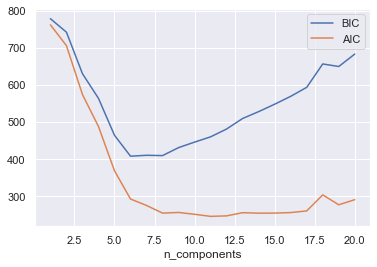

In [48]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(X_moon)
         for n in n_components]

plt.plot(n_components, [m.bic(X_moon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(X_moon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components')

### Example: GMM to generate new data

In [49]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

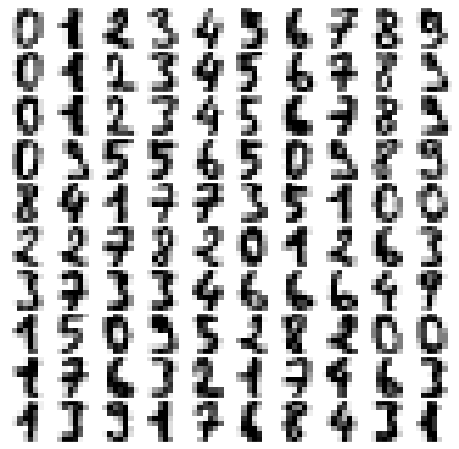

In [52]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                          subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

In [55]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

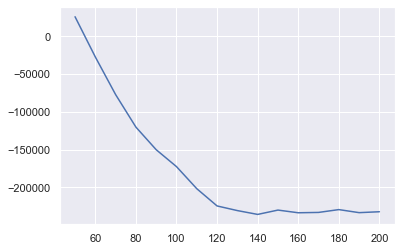

In [57]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
         for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics)

In [60]:
gmm = GMM(140, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

True


In [67]:
data_new = gmm.sample(100)[0]

In [68]:
data_new.shape

(100, 41)

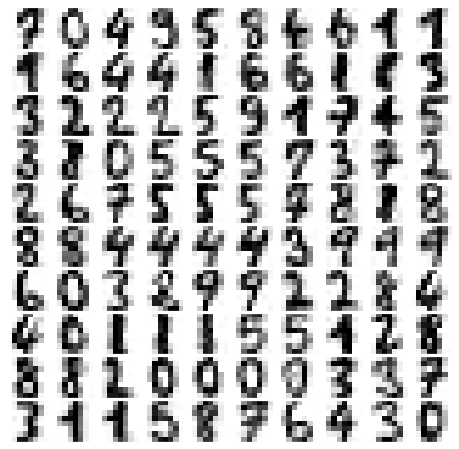

In [69]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)